In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [3]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from random import randint
import math
from collections import defaultdict
from pyvirtualdisplay import Display

### Part 0: Explore the mountain car environment

Discrete(3)
Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
0.07
[-1.2  -0.07]
[0.6  0.07]


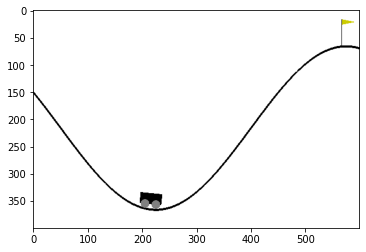

In [5]:
display = Display(visible=0, size=(400, 300))
display.start()
env = gym.make('MountainCar-v0')
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

print(env.action_space)
print(env.observation_space)
print(env.env.max_speed)
print(env.observation_space.low)
print(env.observation_space.high)

Helper functions:

In [29]:
def print_episode_steps(episode_steps, model):
    # print(Q)
    plt.plot(episode_steps)
    plt.xscale("log")
    plt.xlabel("Episodes")
    plt.ylabel("Steps can achieve")
    plt.title("Steps of episodes for " + model)
    plt.show()

def print_episode_time(episode_time, model):
    # print(Q)
    plt.plot(episode_time)
    # plt.xscale("log")
    plt.xlabel("Episodes")
    plt.ylabel("Episodes Runtime")
    plt.title("Episode runtime for " + model) 
    plt.show()

def test_policy(Q):
    avg_steps = []
    for iter in range(50):
      obs = env.reset()
      for i in range(50000):
        state_key = get_discrete_state(obs)
        if state_key in Q:
          # print("State found in :", state_key)
          action = np.argmax(Q[state_key])
          # print("Action chosen:", action)
        else:
          action = env.action_space.sample()
        # print("step i",i,"action=",action)
        obs, reward, done, info = env.step(action)
        # print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
        if done:
          avg_steps.append(i+1)
          # print("Iterations that were run:", i+1)
          break
    avg = sum(avg_steps)/len(avg_steps)
    # print("Average steps for policy:", avg)
    return avg

def print_model_performance_result(Q, episode_steps, episode_time, epsilon, alpha, discount, model_name):
    print("--------------" + model_name + " performance result--------------")
    print("Model parameters: ")
    print("Epsilon: ", epsilon)
    print("Alpha: ", alpha)
    print("Discount/gamma: ", discount)
    print("Model episode step plot:")
    print_episode_steps(episode_steps, model_name)
    print("Model average steps over 50 test games: ", test_policy(Q))
    print("Model learning steps average over 20000 episode: ", sum(episode_steps)/len(episode_steps))
    print("Model learning steps variance over 20000 episode: ", np.var(episode_steps))
    print("Model episode runtime plot and average runtime:")
    print_episode_time(episode_time, "on-policy sarsa")
    print("Average runtime of each on-policy sarsa episode: ", sum(episode_time)/len(episode_time))

def policy(env, state, Q, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])

def get_discrete_state(state):
    bucket = list(zip(env.observation_space.low, env.observation_space.high))
    bucket[0] = [-1.0, 0.5]
    bucket[1] = [-0.07, 0.07]
    bucket_num = (20, 20)
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= bucket[i][0]:
            bucket_index = 0
        elif state[i] >= bucket[i][1]:
            bucket_index = bucket_num[i] - 1
        else:
            # Mapping state to bucket
            scale = (bucket[i][1] - bucket[i][0])/(bucket_num[i]-1)
            state_offset = state[i] - bucket[i][0]
            bucket_index = int(round(state_offset/scale))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)   

### Part 1: TD(0)

Three TD(0) models including on-policy sarsa, on-policy expected sarsa and off-policy expected sarsa with greedy control policy are built in this part. Each model is learning through 20000 episode to benchmark performance, average steps(rewards), variance of episode steps(rewards) and average runtime for each episode are recorded. Moreover, the final learnt policy is tested on 50 independent mountain car games, and average steps(rewards) is also presented.

#### **1. On-policy Sarsa**


In [20]:
episodes = 20000
epsilon = 0.1
alpha = 0.1
discount = 0.99

Q = defaultdict(lambda:np.zeros(env.action_space.n))
episode_steps = []
episode_time = []
for i in range(episodes):
    start = time.time()
    # if i == 5000:
    #   epsilon = epsilon/2
    state = env.reset()
    iteration = 0
    while True:
        iteration += 1
        state_key = get_discrete_state(state)
        action = policy(env, state_key, Q, epsilon)
        q_now = Q[state_key][action]
        next_state, reward, done, _ = env.step(action)
        next_state_key = get_discrete_state(next_state)
        next_action = policy(env, next_state_key, Q, epsilon)
        q_next = Q[next_state_key][next_action]
        Q[state_key][action] += alpha * (reward + discount*q_next - q_now)
        if done:
            # print("Total iteration done:", iteration)
            episode_steps.append(iteration)
            end = time.time()
            episode_time.append(end - start)
            break
        state = next_state

--------------on-policy sarsa performance result--------------
Model parameters: 
Epsilon:  0.1
Alpha:  0.1
Discount/gamma:  0.99
Model episode step plot:


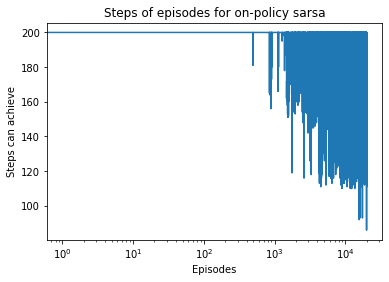

Model average steps over 50 test games:  156.14
Model training steps average over 20000 episode:  177.81415
Model training steps variance over 20000 episode:  527.8797097775
Model episode runtime plot and average runtime:


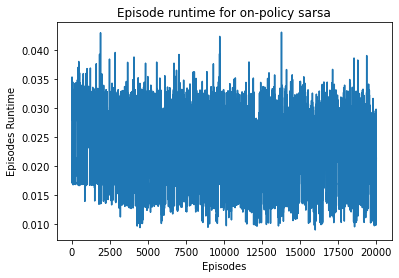

Average runtime of each on-policy sarsa episode:  0.023340987074375152


In [27]:
print_model_performance_result(Q, episode_steps, episode_time, epsilon, alpha, discount, "on-policy sarsa")

#### **2. On-policy Expected Sarsa**

In [28]:
episodes = 20000
epsilon = 0.1
alpha = 0.2
discount = 0.99

Q = defaultdict(lambda:np.zeros(env.action_space.n))
episode_steps = []
non_greedy_p = epsilon/env.action_space.n
greedy_p = 1 - epsilon + non_greedy_p
episode_time = []

for i in range(episodes):
    start = time.time()
    state = env.reset()
    iteration = 0
    while True:
        iteration += 1
        state_key = get_discrete_state(state)
        action = policy(env, state_key, Q, epsilon)
        q_now = Q[state_key][action]
        
        next_state, reward, done, _ = env.step(action)
        next_state_key = get_discrete_state(next_state)
        q_max = max(Q[next_state_key])
        expected_q = 0
        for a in Q[next_state_key]:
            if a == q_max:
                expected_q += q_max * greedy_p
            else:
                expected_q += a * non_greedy_p

        Q[state_key][action] += alpha * (reward + discount*expected_q - q_now)
        if done:
            episode_steps.append(iteration)
            end = time.time()
            episode_time.append(end - start)
            break
        state = next_state

--------------On-policy Expected Sarsa performance result--------------
Model parameters: 
Epsilon:  0.1
Alpha:  0.2
Discount/gamma:  0.99
Model episode step plot:


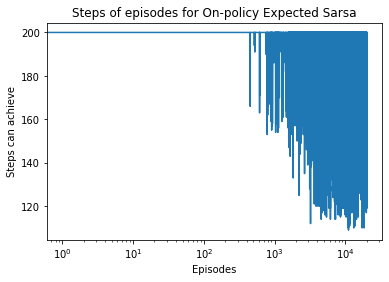

Model average steps over 50 test games:  175.2
Model learning steps average over 20000 episode:  183.09555
Model learning steps variance over 20000 episode:  442.5472201975
Model episode runtime plot and average runtime:


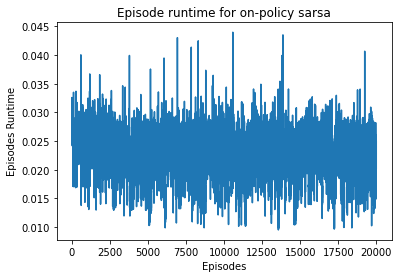

Average runtime of each on-policy sarsa episode:  0.022634520614147186


In [30]:
print_model_performance_result(Q, episode_steps, episode_time, epsilon, alpha, discount, "On-policy Expected Sarsa")

#### **3. Off-policy Expected Sarsa with Greedy Policy (Q-Learning)**
Set epsilon to be 0.5 so that behavior policy can keep exploring, while updating Q using target greedy policy.

In [31]:
episodes = 20000
epsilon = 0.4
alpha = 0.1
discount = 0.99

Q = defaultdict(lambda:np.zeros(env.action_space.n))
episode_steps = []
episode_time = []

for i in range(episodes):
    start = time.time()
    state = env.reset()
    iteration = 0
    while True:
        iteration += 1
        state_key = get_discrete_state(state)
        action = policy(env, state_key, Q, epsilon)
        q_now = Q[state_key][action]
        next_state, reward, done, _ = env.step(action)
        next_state_key = get_discrete_state(next_state)
        q_next = max(Q[next_state_key])
        Q[state_key][action] += alpha * (reward + discount*q_next - q_now)
        if done:
            episode_steps.append(iteration)
            end = time.time()
            episode_time.append(end - start)
            break
        state = next_state

--------------off-policy expected sarsa greedy policy performance result--------------
Model parameters: 
Epsilon:  0.4
Alpha:  0.1
Discount/gamma:  0.99
Model episode step plot:


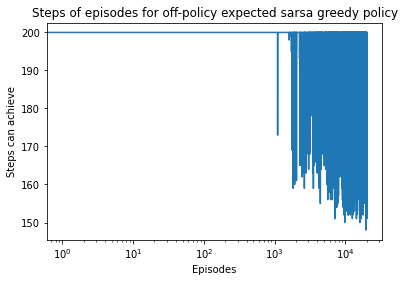

Model average steps over 50 test games:  139.86
Model learning steps average over 20000 episode:  198.17085
Model learning steps variance over 20000 episode:  53.37866027749999
Model episode runtime plot and average runtime:


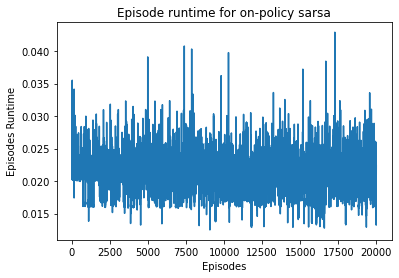

Average runtime of each on-policy sarsa episode:  0.020931775307655335


In [34]:
print_model_performance_result(Q, episode_steps, episode_time, epsilon, alpha, discount, "off-policy expected sarsa greedy policy")

#### **TD(0) Model Comparision:**
 Model performance comparision:

 |Model             | Parameters         |Runtime per episode|Average steps over 50 test games|Average steps over 20000 episode     | Variance|
 |------------------|--------------------|-------------------|--------------------|--------------------|---------|
 |On-policy SARSA   |Epsilon=0.1, Alpha=0.1, Discount=0.99     |0.0233    |156.14 |177.81     |527.88|
 |On-policy expected SARSA|Epsilon=0.1, Alpha=0.2, Discount=0.99 |0.0226 |175.2  |183.095 |442.55|
 |Off-policy expected SARSA with Greedy Policy|Epsilon=0.4, Alpha=0.1, Discount=0.99|0.0209|139.86|198.17|139.86|

As the performance table shows, all three models perform well with a small alpha and close to 1 discount gamma. off-policy expected sarsa with greedy control policy has the slightly lower average runtime for each episode comparing to the other two models. On-policy sarsa achieves the best average steps while learning 20000 episode, however, due to the randomness nature when updating value function, it has the highest variance among all three models. on-policy expected sarsa improved on this as it consider expected value of all state-action pairs. Off-policy expected sarsa achieves the lowest variance as it separate the target policy and behavioural exploration policy. It is also the best performed policy on 50 test games, which has an average of 139.86 steps. It balances both the exploration of state-action and updating value function efficiently to search for optimal policy.

### Part 2 TD(n)

In this section, three TD(n) models are implemented and compared: TD(2), TD(3), TD(4). Model performance statistics are printed. Moreover, final policy produced by each model is tested with 50 independent games, average steps(rewards) for test games is recorded. Epsilon greedy policy is used for all three algorithms.

In [48]:
def td_n(env, num_episodes, n, discount, alpha, epsilon):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    episode_steps = []
    episode_time  = []

    for i_episode in range(num_episodes):
        start = time.time()
        T = math.inf
        tau = 0
        t = -1
        actions_list = {}
        rewards_list = {}
        states_list = {}
        state = env.reset()
        state_key = get_discrete_state(state)
        action = policy(env, state_key, Q, epsilon)
        actions_list[0] = action
        states_list[0] = state_key
        iteration = 0

        while tau < (T - 1):
            t += 1
            if t < T:
                iteration += 1
                state, reward, done, _ = env.step(action)
                state_key = get_discrete_state(state)
                rewards_list[t+1] = reward
                states_list[t+1] = state_key
                
                if done: T = t + 1
                else:
                    action = policy(env, state_key, Q, epsilon)
                    actions_list[t+1] = action
            tau = t - n + 1
            if tau >= 0:
                G = np.sum([discount**(i-tau-1)*rewards_list[i] for i in range(tau+1, min(tau+n, T)+1)])
                if tau + n < T:
                    G += discount**n * Q[states_list[tau+n]][actions_list[tau+n]]
                tau_s, tau_a = states_list[tau], actions_list[tau]
                Q[tau_s][tau_a] += alpha * (G - Q[tau_s][tau_a])

        episode_steps.append(iteration)
        end = time.time()
        episode_time.append(end - start)
    return Q, episode_steps, episode_time

#### **1. TD(2)**

--------------TD(2) performance result--------------
Model parameters: 
Epsilon:  0.1
Alpha:  0.1
Discount/gamma:  0.99
Model episode step plot:


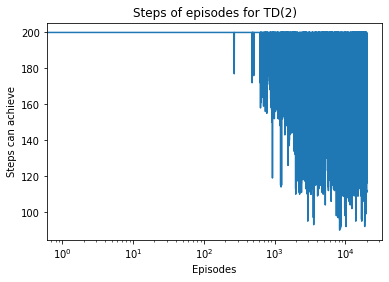

Model average steps over 50 test games:  128.94
Model learning steps average over 20000 episode:  162.2579
Model learning steps variance over 20000 episode:  670.71988759
Model episode runtime plot and average runtime:


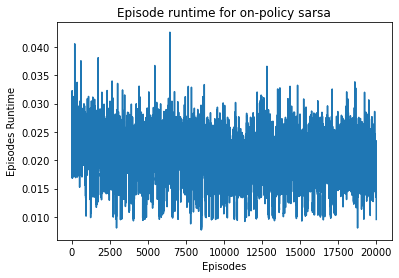

Average runtime of each on-policy sarsa episode:  0.0199866117477417


In [59]:
Q, episode_steps, episode_time = td_n(env, 20000, 2, 0.99, 0.1, 0.1)
print_model_performance_result(Q, episode_steps, episode_time, 0.1, 0.1, 0.99, "TD(2)")

#### **2. TD(3)**

--------------TD(3) performance result--------------
Model parameters: 
Epsilon:  0.1
Alpha:  0.1
Discount/gamma:  0.99
Model episode step plot:


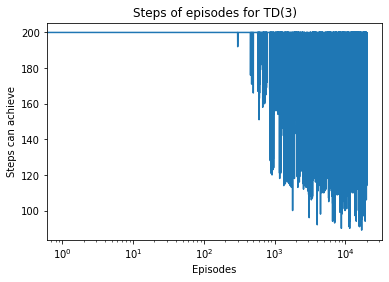

Model average steps over 50 test games:  157.86
Model learning steps average over 20000 episode:  158.8148
Model learning steps variance over 20000 episode:  702.9557009600001
Model episode runtime plot and average runtime:


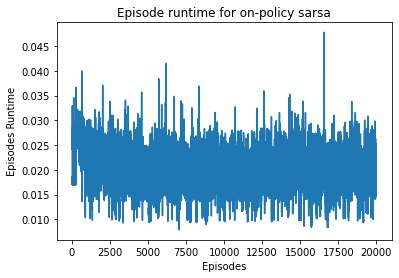

Average runtime of each on-policy sarsa episode:  0.019648933959007263


In [60]:
Q, episode_steps, episode_time = td_n(env, 20000, 3, 0.99, 0.1, 0.1)
print_model_performance_result(Q, episode_steps, episode_time, 0.1, 0.1, 0.99, "TD(3)")

#### **3. TD(4)**

--------------TD(4) performance result--------------
Model parameters: 
Epsilon:  0.1
Alpha:  0.1
Discount/gamma:  0.99
Model episode step plot:


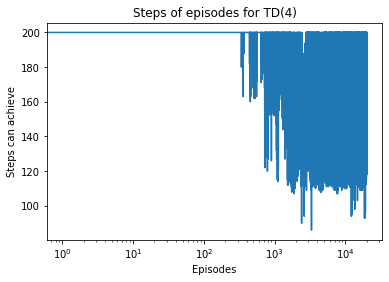

Model average steps over 50 test games:  179.5
Model learning steps average over 20000 episode:  159.77595
Model learning steps variance over 20000 episode:  750.9192515975001
Model episode runtime plot and average runtime:


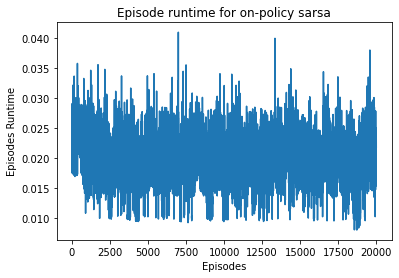

Average runtime of each on-policy sarsa episode:  0.01964182082414627


In [61]:
Q, episode_steps, episode_time = td_n(env, 20000, 4, 0.99, 0.1, 0.1)
print_model_performance_result(Q, episode_steps, episode_time, 0.1, 0.1, 0.99, "TD(4)")

#### **TD(n) Model Comparision:**
 Model performance comparision:

 |Model             | Parameters         |Runtime per episode|Average steps over 50 test games|Average steps over 20000 episode     | Variance|
 |------------------|--------------------|-------------------|--------------------|--------------------|---------|
 |On-policy SARSA   |Epsilon=0.1, Alpha=0.1, Discount=0.99     |0.0233    |156.14 |177.81     |527.88|
 |On-policy expected SARSA|Epsilon=0.1, Alpha=0.2, Discount=0.99 |0.0226 |175.2  |183.095 |442.55|
 |Off-policy expected SARSA with Greedy Policy|Epsilon=0.4, Alpha=0.1, Discount=0.99|0.0209|139.86|198.17|139.86|
 |TD(2)|Epsilon=0.1, Alpha=0.1, Discount=0.99 | 0.0199|128.94 |162.26 |670.72 |
 |TD(3)|Epsilon=0.1, Alpha=0.1, Discount=0.99 | 0.0197|157.86 |158.81 |702.96 |
 |TD(4)|Epsilon=0.1, Alpha=0.1, Discount=0.99 | 0.0196|179.5  |159.78 |750.92 | 

Parameters selected for three TD(n) models are the same and runtime for each episode is very similar. No significant episode runtime latency is observed for small n values in this case. All three models achieved similar average steps(rewards) over 20000 episodes, around 160. However, step variance across these episodes increased as n value increases: TD(2) has lowest variance while TD(4) has highest variance. As for the final policy, TD(2) outperformed other TD(n) models with a 128.94 average steps out of 50 test games.

Comparing to TD(0) models, TD(n) models all outperformed TD(0) models with a lower average steps(rewards) over 20000 learning episodes, which proves that n-step bootstrapping can estimate value function more accurately. However, TD(n) models in general have higher variance as they have more exploring steps. The best model out of all TD methods is TD(2) which achieved 128.94 on test games. Hence, 2 step bootstrapping is more suitable for this problem.

### Part 3 Bonus Task: Tree Backup

In this section, three n-step tree backup models are implemented with n=2,3,4. Model performance is printed and final policy is tested on 50 games. Average steps(rewards) of 50 games are presented.

In [71]:
def print_tree_backup_performance_result(Q, episode_steps, episode_time, alpha, discount, model_name):
    print("--------------" + model_name + " performance result--------------")
    print("Model parameters: ")
    print("Alpha: ", alpha)
    print("Discount/gamma: ", discount)
    print("Model episode step plot:")
    print_episode_steps(episode_steps, model_name)
    print("Model average steps over 50 test games: ", test_policy(Q))
    print("Model learning steps average over 20000 episode: ", sum(episode_steps)/len(episode_steps))
    print("Model learning steps variance over 20000 episode: ", np.var(episode_steps))
    print("Model episode runtime plot and average runtime:")
    print_episode_time(episode_time, "on-policy sarsa")
    print("Average runtime of each on-policy sarsa episode: ", sum(episode_time)/len(episode_time))

def get_greedy_policy(Q, state):
    A = np.zeros(env.action_space.n, dtype=float)
    best_action = np.argmax(Q[state])
    A[best_action] = 1.0
    return A

def n_step_tree_backup(env, num_episodes, n, discount, alpha):
  Q = defaultdict(lambda: np.zeros(env.action_space.n))
  episode_steps = []
  episode_time  = []

  for i_episode in range(num_episodes):  
      start = time.time()        
      T = math.inf
      tau = 0
      t = -1     
      actions_list = {}
      rewards_list = {}
      states_list = {}
      state = env.reset()
      state_key = get_discrete_state(state)
      action = np.argmax(get_greedy_policy(Q, state_key))
      actions_list[0] = action
      states_list[0] = state_key
      iteration = 0
      
      while tau < (T-1):
          t+=1
          iteration += 1
          if t < T:
              state, reward, done, _ = env.step(action)
              state_key = get_discrete_state(state)
              
              states_list[t+1] = state_key
              rewards_list[t+1] = reward
              
              if done:
                  T = t+1
              else:
                  action = np.argmax(get_greedy_policy(Q, state_key))
                  actions_list[t+1] = action
                  
          tau = t - n + 1
          if tau >= 0:
              if (t + 1) >= T:
                  G = rewards_list[T]
              else:
                  s_t1 = states_list[t+1]
                  leaf_sum = np.sum(
                      [(get_greedy_policy(Q, s_t1)[a])*Q[s_t1][a] for a in range(env.action_space.n)])
                  G = rewards_list[t+1] + discount * leaf_sum
              
              for k in range(min(t, T-1), tau, -1):
                  s_k, a_k = states_list[k], actions_list[k]
                  a_probs = np.sum([get_greedy_policy(Q, s_k)[a]* Q[s_k][a] for a in range(env.action_space.n) if a!= a_k])
                  G = rewards_list[k] + discount * (a_probs + get_greedy_policy(Q, s_k)[a_k]*G)
              
              s_tau, a_tau = states_list[tau], actions_list[tau]
              Q[s_tau][a_tau] += alpha * (G - Q[s_tau][a_tau])
      episode_steps.append(iteration)
      end = time.time()
      episode_time.append(end - start)       
  return Q, episode_steps, episode_time

#### **1. Tree backup (2)**

--------------Tree Backup (2) performance result--------------
Model parameters: 
Alpha:  0.1
Discount/gamma:  0.99
Model episode step plot:


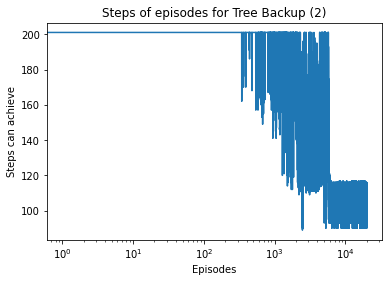

Model average steps over 50 test games:  109.06
Model learning steps average over 20000 episode:  125.273
Model learning steps variance over 20000 episode:  877.011371
Model episode runtime plot and average runtime:


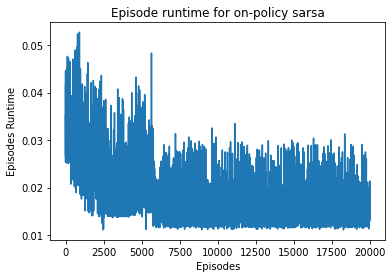

Average runtime of each on-policy sarsa episode:  0.016788482236862183


In [72]:
Q, episode_steps, episode_time = n_step_tree_backup(env, 20000, 2, 0.99, 0.1)
print_tree_backup_performance_result(Q, episode_steps, episode_time, 0.1, 0.99, "Tree Backup (2)")

#### **2. Tree backup (3)**

--------------Tree Backup (3) performance result--------------
Model parameters: 
Alpha:  0.1
Discount/gamma:  0.99
Model episode step plot:


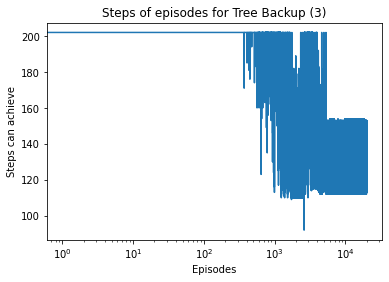

Model average steps over 50 test games:  132.9
Model learning steps average over 20000 episode:  141.37365
Model learning steps variance over 20000 episode:  513.2530356775001
Model episode runtime plot and average runtime:


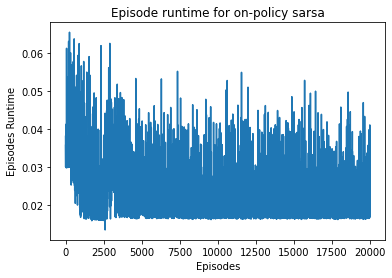

Average runtime of each on-policy sarsa episode:  0.02239222159385681


In [73]:
Q, episode_steps, episode_time = n_step_tree_backup(env, 20000, 3, 0.99, 0.1)
print_tree_backup_performance_result(Q, episode_steps, episode_time, 0.1, 0.99, "Tree Backup (3)")

#### **3. Tree backup (4)**

--------------Tree Backup (4) performance result--------------
Model parameters: 
Alpha:  0.1
Discount/gamma:  0.99
Model episode step plot:


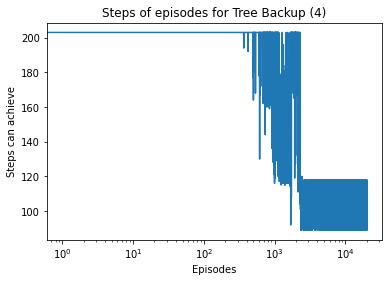

Model average steps over 50 test games:  108.76
Model learning steps average over 20000 episode:  118.7419
Model learning steps variance over 20000 episode:  607.95338439
Model episode runtime plot and average runtime:


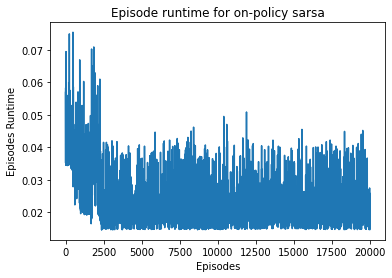

Average runtime of each on-policy sarsa episode:  0.02148280748128891


In [74]:
Q, episode_steps, episode_time = n_step_tree_backup(env, 20000, 4, 0.99, 0.1)
print_tree_backup_performance_result(Q, episode_steps, episode_time, 0.1, 0.99, "Tree Backup (4)")

#### **Tree backup Model Comparision:**
Model performance comparision:

 |Model             | Parameters         |Runtime per episode|Average steps over 50 test games|Average steps over 20000 episode     | Variance|
 |------------------|--------------------|-------------------|--------------------|--------------------|---------|
 |On-policy SARSA   |Epsilon=0.1, Alpha=0.1, Discount=0.99     |0.0233    |156.14 |177.81     |527.88|
 |On-policy expected SARSA|Epsilon=0.1, Alpha=0.2, Discount=0.99 |0.0226 |175.2  |183.095 |442.55|
 |Off-policy expected SARSA with Greedy Policy|Epsilon=0.4, Alpha=0.1, Discount=0.99|0.0209|139.86|198.17|139.86|
 |TD(2)|Epsilon=0.1, Alpha=0.1, Discount=0.99 | 0.0199|128.94 |162.26 |670.72 |
 |TD(3)|Epsilon=0.1, Alpha=0.1, Discount=0.99 | 0.0197|157.86 |158.81 |702.96 |
 |TD(4)|Epsilon=0.1, Alpha=0.1, Discount=0.99 | 0.0196|179.5  |159.78 |750.92 |
 |Tree Backup (2)|Alpha=0.1, Discount=0.99 |0.0168 |109.06 |125.27 |877.01 |
 |Tree Backup (3)|Alpha=0.1, Discount=0.99 |0.0224 |132.9 |141.37 |513.25 |
 |Tree Backup (4)|Alpha=0.1, Discount=0.99 |0.0215 |108.76 |118.74 |607.95 |

Parameters selected for all three tree backup models are the same. It observed that n-step tree backup models outperformed all other TD methods, achieving an average steps(rewards) over 20000 episodes of around 130. This is a big improvement, from the episode steps plot, we can observe that learnt policy can stabilized at a low step number(higher rewards) till the end of 20000 episodes. Tree backup methods also have lower variance comparing to TD(n), which indicates the benefit of off-policy.